<a href="https://www.kaggle.com/code/giuliobenedetti/imagenet-reproducing-convnets?scriptVersionId=156890068" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Overview

In this notebook, we aim to reproduce the model from [_Simonyan & Zisserman 2015_](https://arxiv.org/pdf/1409.1556v6.pdf). In other words, we will design an analogous model on TensorFlow, train it with the data from the [ImageNet Object Classification Challenge](https://www.kaggle.com/competitions/imagenet-object-localization-challenge) and ultimately benchmark its performance with the original model.

In [1]:
# Import packages

# Data analysis
import numpy as np
import pandas as pd

# File management
import os
import shutil

# Image visualisation
import matplotlib.pyplot as plt

# Neural network
import tensorflow as tf
from tensorflow import keras
from keras import layers

# Custom utilities
import utilities_for_vgg as vggutils

# Hide warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
# If TPU is available
try:
    # Detect TPU
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver() 
    print('Running on TPU ', tpu.master())

except:
    tpu = None
    

# If TPU is defined
if tpu:
    # Initialise TPU
    tf.tpu.experimental.initialize_tpu_system(tpu)
    # Instantiate a TPU distribution strategy
    strategy = tf.distribute.experimental.TPUStrategy(tpu)

else:
    # Or instanstiate available strategy
    strategy = tf.distribute.get_strategy() 

print("REPLICAS: ", strategy.num_replicas_in_sync)

Running on TPU  
INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.
INFO:tensorflow:Initializing the TPU system: local


2023-12-28 18:30:15.483080: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-12-28 18:30:15.483177: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-12-28 18:30:15.483276: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-12-28 18:30:15.483374: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-12-28 18:30:15.483449: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-12-28 18:30:15.483655: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-12-28 18:30:15.483742: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority un

INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


REPLICAS:  8


Here we list the constants that will be used for preprocessing and model design.

In [3]:
# Define constants

# Set seed for reproducibility
SEED = 0
# Set batch size for mini-batch gradient descent
BATCH_SIZE = 16 * strategy.num_replicas_in_sync
# Set number of epochs to train model
EPOCH_NUM = 50

# Set kernel size for Conv2D layers
KERNEL_SIZE = 3
# Set padding mode for Conv2D layers
PAD_MODE = "same"
# Set activation function for Conv2D layers
ACTIVATION = "relu"

# Set pool size for MaxPool2D layers
POOL_SIZE = 2
# Set strides for MaxPool2D layers
POOL_STRIDES = 2

# Data Preprocessing

Because the train set is big (`train_dir`), we take a subset of classes defined by `CLASS_NUM` and process the images belonging to that subset of classes by rescaling and cropping them. Initially, we will train the model using only this subset.

In [4]:
# Store paths to base, train set and subset dirs
base_dir = "/kaggle/input/imagenet-object-localization-challenge/"
data_dir = base_dir + "ILSVRC/Data/CLS-LOC/"

# Fetch train set
raw_train_ds = tf.data.Dataset.list_files(data_dir + "train/n01*/*.JPEG", shuffle=False)

# Find size of train set
train_size = tf.data.experimental.cardinality(raw_train_ds).numpy()

# Shuffle train set
raw_train_ds = raw_train_ds.shuffle(train_size, reshuffle_each_iteration=False, seed=SEED)

print(f"Size of train set: {train_size}")

Size of train set: 164467


In [24]:
# Import devel labels
devel_df = pd.read_csv(base_dir + "LOC_val_solution.csv")

# Select devel images belonging to subset of classes
keep = devel_df["PredictionString"].str.startswith("n01")
devel_df = devel_df[keep]

# Replace prediction string with only class name
devel_df["PredictionString"] = devel_df["PredictionString"].str.split(expand=True)[0]

# Sort and polish dataframe
devel_df.sort_values(by=["ImageId"], inplace=True)
devel_df.index = range(len(devel_df))

# Fetch devel set
devel_df["ImageId"] = data_dir + "val/" + devel_df["ImageId"] + ".JPEG"
raw_devel_ds = tf.data.Dataset.list_files(devel_df["ImageId"], shuffle=False)

# Find size of devel set
devel_size = tf.data.experimental.cardinality(raw_devel_ds).numpy()

print(f"Size of devel set: {devel_size}")
print("Examples of labels:")
devel_df["PredictionString"].values[:10]

Size of devel set: 6350
Examples of labels:


array(['n01751748', 'n01735189', 'n01917289', 'n01914609', 'n01616318',
       'n01616318', 'n01729977', 'n01644900', 'n01773797', 'n01828970'],
      dtype=object)

In [25]:
# Find class names from dir names
class_names = np.array(sorted([dir for dir in os.listdir(data_dir + "train/") if dir.startswith("n01")]))

# Set number of classes
CLASS_NUM = len(class_names)

for f in raw_train_ds.take(5):
    print(f.numpy())

b'/kaggle/input/imagenet-object-localization-challenge/ILSVRC/Data/CLS-LOC/train/n01689811/n01689811_5997.JPEG'
b'/kaggle/input/imagenet-object-localization-challenge/ILSVRC/Data/CLS-LOC/train/n01693334/n01693334_8633.JPEG'
b'/kaggle/input/imagenet-object-localization-challenge/ILSVRC/Data/CLS-LOC/train/n01847000/n01847000_1697.JPEG'
b'/kaggle/input/imagenet-object-localization-challenge/ILSVRC/Data/CLS-LOC/train/n01682714/n01682714_14866.JPEG'
b'/kaggle/input/imagenet-object-localization-challenge/ILSVRC/Data/CLS-LOC/train/n01667114/n01667114_8210.JPEG'


tf.Tensor(109, shape=(), dtype=int64)


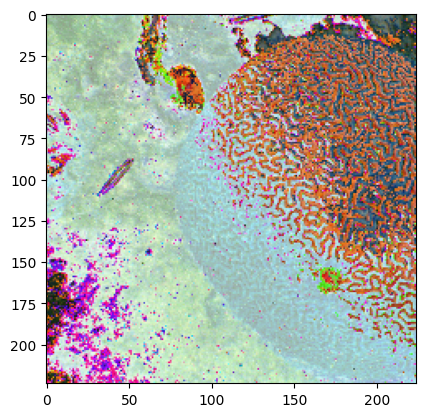

In [58]:
image, label = vggutils.process_path(
    data_dir + "val/ILSVRC2012_val_00000011.JPEG",
    class_names,
    devel_df,
    label_fun=vggutils.extract_devel_label
)

input_shape = image.shape

plt.imshow(image)
print(label)

In [69]:
# Preprocess train set
train_ds = raw_train_ds.map(
    lambda path: vggutils.process_path(path, class_names, devel_df, label_fun=vggutils.extract_train_label),
    num_parallel_calls=tf.data.AUTOTUNE
)

# Preprocess devel set
devel_ds = raw_devel_ds.map(
    lambda path: vggutils.process_path(path, class_names, devel_df, label_fun=vggutils.extract_devel_label, max_delta=0),
    num_parallel_calls=tf.data.AUTOTUNE
)

# Show example
for image, label in devel_ds.take(30):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (224, 224, 3)
Label:  65
Image shape:  (224, 224, 3)
Label:  65
Image shape:  (224, 224, 3)
Label:  65
Image shape:  (224, 224, 3)
Label:  65
Image shape:  (224, 224, 3)
Label:  65
Image shape:  (224, 224, 3)
Label:  65
Image shape:  (224, 224, 3)
Label:  65
Image shape:  (224, 224, 3)
Label:  65
Image shape:  (224, 224, 3)
Label:  65
Image shape:  (224, 224, 3)
Label:  65
Image shape:  (224, 224, 3)
Label:  65
Image shape:  (224, 224, 3)
Label:  65
Image shape:  (224, 224, 3)
Label:  65
Image shape:  (224, 224, 3)
Label:  65
Image shape:  (224, 224, 3)
Label:  65
Image shape:  (224, 224, 3)
Label:  65
Image shape:  (224, 224, 3)
Label:  65
Image shape:  (224, 224, 3)
Label:  65
Image shape:  (224, 224, 3)
Label:  65
Image shape:  (224, 224, 3)
Label:  65
Image shape:  (224, 224, 3)
Label:  65
Image shape:  (224, 224, 3)
Label:  65
Image shape:  (224, 224, 3)
Label:  65
Image shape:  (224, 224, 3)
Label:  65
Image shape:  (224, 224, 3)
Label:  65
Image shape:  (224, 224, 

In [61]:
# Improve train set performance
train_ds = train_ds \
    .cache() \
    .shuffle(buffer_size=1000, seed=SEED) \
    .batch(BATCH_SIZE) \
    .prefetch(buffer_size=tf.data.AUTOTUNE)

# Improve devel set performance
devel_ds = devel_ds \
    .batch(BATCH_SIZE) \
    .cache() \
    .prefetch(buffer_size=tf.data.AUTOTUNE)

tf.Tensor(
[[[0.3907276  0.34366876 0.28092366]
  [0.39192417 0.33473942 0.27536964]
  [0.39376667 0.33878994 0.27868414]
  ...
  [0.38211307 0.32343072 0.26456013]
  [0.39136368 0.33254012 0.2737166 ]
  [0.3599323  0.32071662 0.25797153]]

 [[0.39567575 0.3486169  0.2858718 ]
  [0.40647003 0.3542098  0.2931985 ]
  [0.40590224 0.35477617 0.29338682]
  ...
  [0.38104492 0.33131894 0.26946288]
  [0.380959   0.32785696 0.26712626]
  [0.36807933 0.32886365 0.26611856]]

 [[0.3900491  0.34299025 0.28024516]
  [0.39607996 0.3490211  0.286276  ]
  [0.40032038 0.35204187 0.2929558 ]
  ...
  [0.37874594 0.3316871  0.268942  ]
  [0.372929   0.32587016 0.26312506]
  [0.38128403 0.33460814 0.27186304]]

 ...

 [[0.34918728 0.34134415 0.30450326]
  [0.33092788 0.3180086  0.27879292]
  [0.29544896 0.2797627  0.24054702]
  ...
  [0.31217626 0.28648674 0.24509749]
  [0.35095298 0.32341215 0.2766229 ]
  [0.33053464 0.29546955 0.23272446]]

 [[0.29939827 0.29630476 0.2597992 ]
  [0.29910034 0.28377482 0

ValueError: num must be an integer with 1 <= num <= 9, not 10

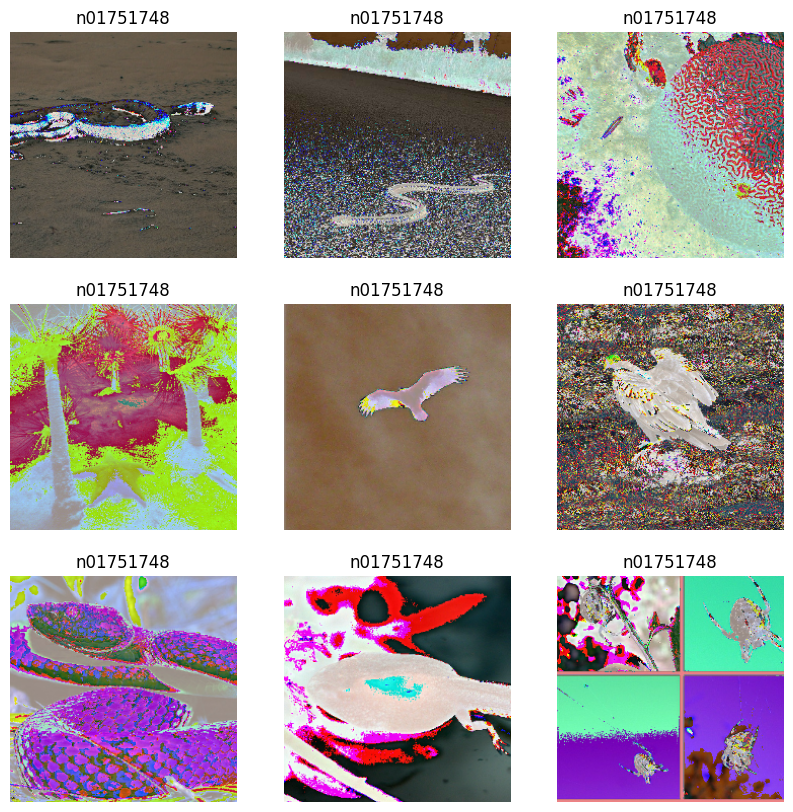

In [66]:
image_batch, label_batch = next(iter(devel_ds))

plt.figure(figsize=(10, 10))
for i in range(30):
    print(image_batch[0])
    print(label_batch[0])
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i])
    label = label_batch[i]
    plt.title(class_names[label])
    plt.axis("off")

# Model Design

In general, the model architecture resembles the model from the paper pretty well, even though some details may still be missing.

In [15]:
# Set up model within scope of tpu strategy
with strategy.scope():
    
    # Make environment more reproducible
    vggutils.reproduce_environment(random_state=SEED)
    
    # Build model
    model = vggutils.design_vgg11(
        class_num=CLASS_NUM,
        input_shape=input_shape,
        kernel_size=KERNEL_SIZE,
        padding=PAD_MODE,
        activation=ACTIVATION,
        pool_size=POOL_SIZE,
        strides=POOL_STRIDES
    )
    
    # Define optimiser
    sgd_optimiser = vggutils.create_optimiser()
    
    # Compile model
    model.compile(
        optimizer = sgd_optimiser,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=["sparse_categorical_accuracy"]
    )

2023-12-28 18:37:10.709687: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-12-28 18:37:10.709839: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.


To test that the model works, we train it for a few epochs. Ideally, we will train the model on the full dataset when once it resembles the model from the paper in terms of parameter number. 

In [17]:
# Update learning rate
LR_Decay = keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.1,
    patience=2,
    mode="min",
    min_delta=1e-4,
    min_lr=1e-5
)

# Train the model
history = model.fit(
    train_ds,
    validation_data=devel_ds,
    epochs=20,
    batch_size=BATCH_SIZE,
    verbose=True,
    callbacks=[LR_Decay]
)

# Store training history as a dataframe
history_df = pd.DataFrame(history.history)

print(f"Train loss: {history_df['loss'].iloc[-1]:.3f}, Devel loss: {history_df['val_loss'].iloc[-1]:.3f}")
print(f"Train accuracy: {history_df['sparse_categorical_accuracy'].iloc[-1]:.3f}, Devel accuracy: {history_df['val_sparse_categorical_accuracy'].iloc[-1]:.3f}")

Epoch 1/5


2023-12-28 18:37:50.151991: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-12-28 18:37:50.169211: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-12-28 18:37:50.185926: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-12-28 18:37:50.202749: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-12-28 18:37:50.219798: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-12-28 18:37:50.236514: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-12-28 18:37:50.253298: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority un

 1/46 [..............................] - ETA: 15:03 - loss: 4.8424 - sparse_categorical_accuracy: 0.0000e+00

2023-12-28 18:38:10.276830: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-12-28 18:38:10.276994: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-12-28 18:38:10.277080: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-12-28 18:38:10.282740: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-12-28 18:38:10.289363: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-12-28 18:38:10.294469: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-12-28 18:38:10.294624: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority un

 4/46 [=>............................] - ETA: 5s - loss: 4.8437 - sparse_categorical_accuracy: 0.0020     

2023-12-28 18:38:10.641528: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.


17/46 [==========>...................] - ETA: 3s - loss: 4.8442 - sparse_categorical_accuracy: 0.0078

2023-12-28 18:38:12.297567: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-12-28 18:38:12.451368: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.


20/46 [============>.................] - ETA: 3s - loss: 4.8445 - sparse_categorical_accuracy: 0.0066

2023-12-28 18:38:12.962369: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.


24/46 [==============>...............] - ETA: 3s - loss: 4.8446 - sparse_categorical_accuracy: 0.0062

2023-12-28 18:38:13.535877: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.


29/46 [=================>............] - ETA: 3s - loss: 4.8446 - sparse_categorical_accuracy: 0.0062

2023-12-28 18:38:15.496858: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.


30/46 [==================>...........] - ETA: 3s - loss: 4.8446 - sparse_categorical_accuracy: 0.0065

2023-12-28 18:38:15.896277: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-12-28 18:38:16.074701: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.


46/46 [==============================] - 46s 568ms/step - loss: 4.8447 - sparse_categorical_accuracy: 0.0073 - val_loss: 4.8539 - val_sparse_categorical_accuracy: 0.0000e+00 - lr: 0.0100
Epoch 2/5
46/46 [==============================] - 14s 304ms/step - loss: 4.8445 - sparse_categorical_accuracy: 0.0065 - val_loss: 4.8269 - val_sparse_categorical_accuracy: 0.0000e+00 - lr: 0.0100
Epoch 3/5
46/46 [==============================] - 16s 345ms/step - loss: 4.8443 - sparse_categorical_accuracy: 0.0085 - val_loss: 4.8328 - val_sparse_categorical_accuracy: 0.0000e+00 - lr: 0.0100
Epoch 4/5
46/46 [==============================] - 13s 289ms/step - loss: 4.8452 - sparse_categorical_accuracy: 0.0056 - val_loss: 4.8671 - val_sparse_categorical_accuracy: 0.0000e+00 - lr: 0.0100
Epoch 5/5
46/46 [==============================] - 14s 303ms/step - loss: 4.8443 - sparse_categorical_accuracy: 0.0097 - val_loss: 4.8644 - val_sparse_categorical_accuracy: 0.0000e+00 - lr: 1.0000e-03
Train loss: 4.844, De

The model contains 128778627 trainable parameters, which aligns pretty well with the 33 million in the paper. Our model may still lack some element responsible for the missing 4 million parameters.

<Axes: title={'center': 'Loss'}>

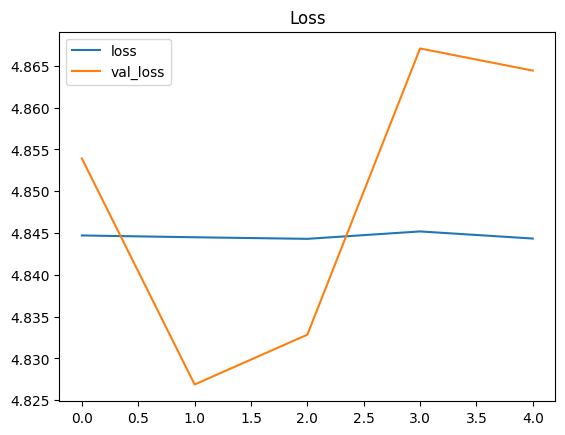

In [18]:
# Visualise loss
history_df.loc[:, ["loss", "val_loss"]].plot(title="Loss")

<Axes: title={'center': 'Accuracy'}>

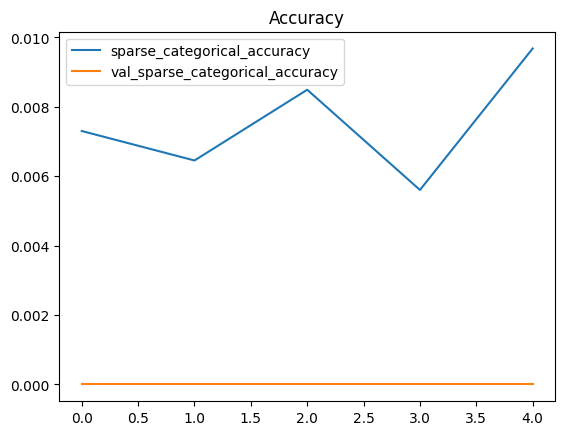

In [19]:
# Visualise accuracy
history_df.loc[:, ["sparse_categorical_accuracy", "val_sparse_categorical_accuracy"]].plot(title="Accuracy")

# Transfer Learning

The next step involves building a deeper ConvNet by:
1. taking the pretrained base from the previous section,
2. enriching it with new untrained convolutional layers and
3. attaching it to a new untrained classification head

By transferring the learnt weight from our previous model, we can build more complex and deeper ConvNets without too much computational burden. In particular, here we aim to reproduce the following four architectures from _Zimonyan & Zisserman 2015_:
- 13-layer ConvNet
- 16-layer ConvNet (with 1-by-1 filters)
- 16-layer ConvNet (with 3-by-3 filters)
- 19-layer ConvNet

In the following cell, we pretend that the previously trained model is stored in a keras file to show how pretrained models can be imported into a notebook.

In [ ]:
# Define model file
model_file = f"/kaggle/working/{CLASS_NUM}class_model.keras"

# Save model into file for replication purposes
model.save(model_file)

Because we want to add new convolutional layers between the pretrained ones, we have to separate the latter from the whole pretrained base as done below.

## 13-layer ConvNet

Here, we build and train a 13-layer ConvNet with a half pretrained half untrained base.

In [ ]:
# Set up model within scope of tpu strategy
with strategy.scope():
    
    # Make environment more reproducible
    vggutils.reproduce_environment(random_state=SEED)
    
    # Build model
    model = vggutils.design_vgg13(
        model_file=model_file,
        kernel_size=KERNEL_SIZE,
        padding=PAD_MODE,
        activation=ACTIVATION,
        pool_size=POOL_SIZE,
        strides=POOL_STRIDES
    )
    
    # Define optimiser
    sgd_optimiser = vggutils.create_optimiser()
    
    # Compile model
    model.compile(
        optimizer = sgd_optimiser,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=["sparse_categorical_accuracy"]
    )

In [ ]:
# Update learning rate
LR_Decay = keras.callbacks.ReduceLROnPlateau(
    monitor="loss",
    factor=0.1,
    patience=2,
    mode="min",
    min_delta=1e-4,
    min_lr=1e-5
)

# Train the model
history = model.fit(
    train_ds,
    validation_data=devel_ds,
    epochs=10,
    batch_size=BATCH_SIZE,
    verbose=True,
    callbacks=[LR_Decay]
)

# Store training history as a dataframe
history_df = pd.DataFrame(history.history)

print(f"Train loss: {history_df['loss'].iloc[-1]:.3f}, Devel loss: {history_df['val_loss'].iloc[-1]:.3f}")
print(f"Train accuracy: {history_df['sparse_categorical_accuracy'].iloc[-1]:.3f}, Devel accuracy: {history_df['val_sparse_categorical_accuracy'].iloc[-1]:.3f}")

In [ ]:
# Visualise loss
history_df.loc[:, ["loss", "val_loss"]].plot(title="Loss")

In [ ]:
# Visualise accuracy
history_df.loc[:, ["sparse_categorical_accuracy", "val_sparse_categorical_accuracy"]].plot(title="Accuracy")